In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import os
import matplotlib.colors as clrs
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
fp_ds1 = "./DS1_not_balanced_just_scaled.csv"

original = pd.read_csv(fp_ds1, parse_dates=False, sep=',',index_col=0)

my_palette = {'yellow': '#ECD474', 'pale orange': '#E9AE4E', 'salmon': '#E2A36B', 'orange': '#F79522', 'dark orange': '#D7725E',
              'pale acqua': '#92C4AF', 'acqua': '#64B29E', 'marine': '#3D9EA9', 'green': '#10A48A', 'olive': '#99C244',
              'pale blue': '#BDDDE0', 'blue2': '#199ED5', 'blue3': '#1DAFE5', 'dark blue': '#0C70B2',
              'pale pink': '#D077AC', 'pink': '#EA4799', 'lavender': '#E09FD5', 'lilac': '#B081B9', 'purple': '#923E97',
              'white': '#FFFFFF', 'light grey': '#D2D3D4', 'grey': '#939598', 'black': '#000000'}

In [2]:
import datetime as dt

NR_COLUMNS: int = 3
HEIGHT: int = 4


def choose_grid(nr):
    if nr < NR_COLUMNS:
        return 1, nr
    else:
        return (nr // NR_COLUMNS, NR_COLUMNS) if nr % NR_COLUMNS == 0 else (nr // NR_COLUMNS + 1, NR_COLUMNS)


def set_axes(xvalues: list, ax: plt.Axes = None, title: str = '', xlabel: str = '', ylabel: str = '', percentage=False):
    if ax is None:
        ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(xvalues, fontsize='small', ha='center')

    return ax


def set_locators(xvalues: list, ax: plt.Axes = None):
    if isinstance(xvalues[0], dt.datetime):
        locator = mdates.AutoDateLocator()
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator, defaultfmt='%Y-%m-%d'))
    else:
        ax.set_xticks(xvalues)
        ax.set_xlim(xvalues[0], xvalues[-1])

    return ax


def plot_line(xvalues: list, yvalues: list, ax: plt.Axes = None, title: str = '', xlabel: str = '',
              ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)
    ax = set_locators(xvalues, ax=ax)
    ax.plot(xvalues,  yvalues, c=cfg.LINE_COLOR)


def multiple_line_chart(xvalues: list, yvalues: dict, ax: plt.Axes = None, title: str = '',
                        xlabel: str = '', ylabel: str = '', percentage=False, miny=0, maxy=1):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)
    ax = set_locators(xvalues, ax=ax)

    legend: list = []
    if percentage:
        ax.set_ylim(miny-0.1,maxy+0.1)
    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
    ax.legend(legend)


def bar_chart(xvalues: list, yvalues: list, ax: plt.Axes = None, title: str = '',
              xlabel: str = '', ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)
    ax.bar(xvalues, yvalues, edgecolor=my_palette['dark blue'], color=my_palette['pale blue'])


def multiple_bar_chart(xvalues: list, yvalues: dict, ax: plt.Axes = None, title: str = '',
                       xlabel: str = '', ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)

    x = np.arange(len(xvalues))  # the label locations

    width = 0.8 / (len(xvalues)*len(yvalues))
    # the width of the bars
    step = width / len(xvalues)
    i: int = 0
    for metric in yvalues:
        ax.bar(x + i*width, yvalues[metric], width=width, align='center', label=metric)
        i += 1
    ax.set_xticks(x + width/len(xvalues) - step/2)
    ax.legend(fontsize='x-small', title_fontsize='small')


def plot_confusion_matrix(cnf_matrix: np.ndarray, classes_names: np.ndarray,
                          ax: plt.Axes = None, normalize: bool = False):
    if ax is None:
        ax = plt.gca()
    if normalize:
        total = cnf_matrix.sum(axis=1)[:, np.newaxis]
        cm = cnf_matrix.astype('float') / total
        title = "Normalized confusion matrix"
    else:
        cm = cnf_matrix
        title = 'Confusion matrix'
    np.set_printoptions(precision=2)
    tick_marks = np.arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cm, interpolation='nearest', cmap=clrs.LinearSegmentedColormap.from_list("myCMPBlues", [my_palette['pale blue'], my_palette['blue2'], my_palette['blue3'], my_palette['dark blue']]))

    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), color='w', horizontalalignment="center")


def plot_evaluation_results(labels: np.ndarray, trn_y, prd_trn, tst_y, prd_tst):
    cnf_mtx_trn = metrics.confusion_matrix(trn_y, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tst_y, prd_tst, labels)
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()

    evaluation = {'Accuracy': [(tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn),
                               (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)],
                  'Recall': [tp_trn / (tp_trn + fn_trn), tp_tst / (tp_tst + fn_tst)],
                  'Specificity': [tn_trn / (tn_trn + fp_trn), tn_tst / (tn_tst + fp_tst)],
                  'Precision': [tp_trn / (tp_trn + fp_trn), tp_tst / (tp_tst + fp_tst)]}

    fig, axs = plt.subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
    multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets")
    plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1])


def plot_roc_chart(models: dict, tstX: np.ndarray, tstY: np.ndarray, ax: plt.Axes = None, target: str = 'class'):
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel('FP rate')
    ax.set_ylabel('TP rate')
    ax.set_title('ROC chart for %s' % target)

    ax.plot([0, 1], [0, 1], color='navy', label='random', linewidth=1, linestyle='--',  marker='')
    for clf in models.keys():
        metrics.plot_roc_curve(models[clf], tstX, tstY, ax=ax, marker='', linewidth=1)
    ax.legend(loc="lower right")

In [3]:
original.head()
print(original.shape)
y: np.ndarray = original.pop('DEATH_EVENT').values
X: np.ndarray = original.values

labels = pd.unique(y)
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

trnX

(224, 13)


array([[0.18181818, 1.        , 0.01735137, ..., 0.        , 0.        ,
        0.08896797],
       [0.85454545, 1.        , 0.01607553, ..., 1.        , 0.        ,
        0.03558719],
       [0.09090909, 0.        , 0.07131921, ..., 1.        , 0.        ,
        0.20284698],
       ...,
       [0.09090909, 0.        , 0.07131921, ..., 1.        , 0.        ,
        0.03558719],
       [0.27272727, 1.        , 0.01875478, ..., 1.        , 0.        ,
        0.87544484],
       [0.54545455, 0.        , 0.00586884, ..., 0.        , 0.        ,
        0.25266904]])

In [4]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
trnX, trnY = sm.fit_sample(trnX, trnY)
print(trnY)

[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<Figure size 432x288 with 0 Axes>

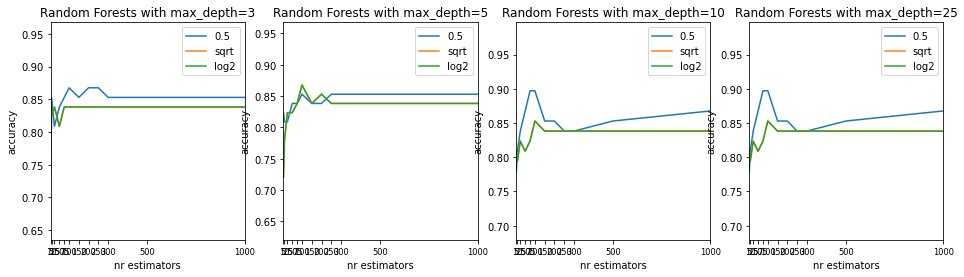

Best results with depth=10, 0.5 features and 75 estimators, with accuracy=0.90


In [5]:

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300,500,1000]
max_depths = [3, 5, 10, 25]
max_features = [0.5, 'sqrt', 'log2']
best = ('', 0, 0)
last_best = 0
best_tree = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*HEIGHT, HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    miny=1
    maxy=0
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n,max_features=f,max_depth=d,min_samples_split=5,random_state=0)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_tree = rf

        values[f] = yvalues
        if (np.min(yvalues))<miny:
            miny=min(yvalues)
        if (np.max(yvalues))>maxy:
            maxy=max(yvalues)
    multiple_line_chart(n_estimators, values, ax=axs[0, k], title=('Random Forests with max_depth={}'.format(d)),
                           xlabel='nr estimators', ylabel='accuracy', percentage=True, miny=miny, maxy=maxy)

plt.show()
print('Best results with depth={}, {} features and {} estimators, with accuracy={:.2f}'.format(best[0], best[1], best[2], last_best))

[0.12766331 0.00542831 0.05885609 0.02111601 0.15698588 0.00595481
 0.04460696 0.14668076 0.02717203 0.00461633 0.00597299 0.39494653]


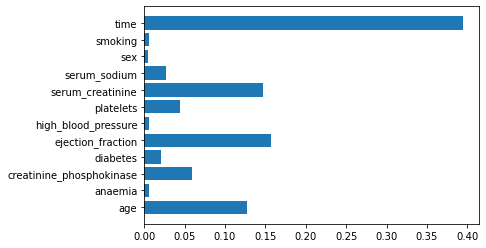

In [6]:
print(best_tree.feature_importances_)
#bar_chart([x for x in original.columns], best_tree.feature_importances_, None,'Feature Importance','Features', 'Importance', True)

plt.barh([x for x in original.columns],best_tree.feature_importances_)
plt.show()

/home/aid/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[1. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


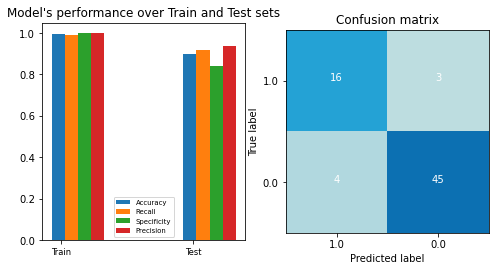

In [7]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)

plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

In [8]:
X = original[['age','ejection_fraction','serum_creatinine','creatinine_phosphokinase','time']]

<Figure size 432x288 with 0 Axes>

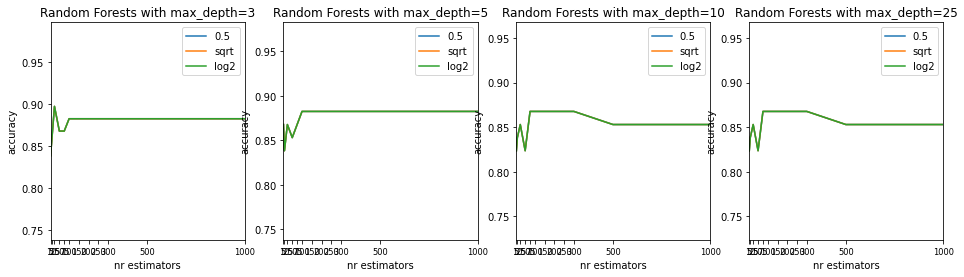

Best results with depth=3, 0.5 features and 25 estimators, with accuracy=0.90


In [9]:
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

sm = SMOTE(sampling_strategy='minority', random_state=42)
trnX, trnY = sm.fit_sample(trnX, trnY)

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300,500,1000]
max_depths = [3, 5, 10, 25]
max_features = [0.5, 'sqrt', 'log2']
best = ('', 0, 0)
last_best = 0
best_tree = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*HEIGHT, HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    miny=1
    maxy=0
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n,max_features=f,max_depth=d,min_samples_split=5,random_state=0)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_tree = rf

        values[f] = yvalues
        if (np.min(yvalues))<miny:
            miny=np.min(yvalues)
        if (np.max(yvalues))>maxy:
            maxy=np.max(yvalues)
    multiple_line_chart(n_estimators, values, ax=axs[0, k], title=('Random Forests with max_depth={}'.format(d)),
                           xlabel='nr estimators', ylabel='accuracy', percentage=True, miny=miny, maxy=maxy)

plt.show()
print('Best results with depth={}, {} features and {} estimators, with accuracy={:.2f}'.format(best[0], best[1], best[2], last_best))


[0.05 0.16 0.21 0.06 0.52]


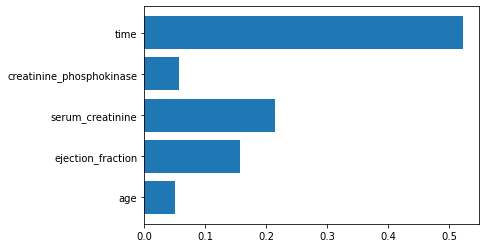

In [10]:
print(best_tree.feature_importances_)
#bar_chart([x for x in original.columns], best_tree.feature_importances_, None,'Feature Importance','Features', 'Importance', True)

plt.barh([x for x in ['age','ejection_fraction','serum_creatinine','creatinine_phosphokinase','time']],best_tree.feature_importances_)
plt.show()

/home/aid/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[1. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


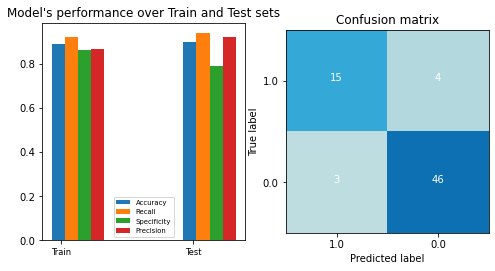

In [11]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

<Figure size 432x288 with 0 Axes>

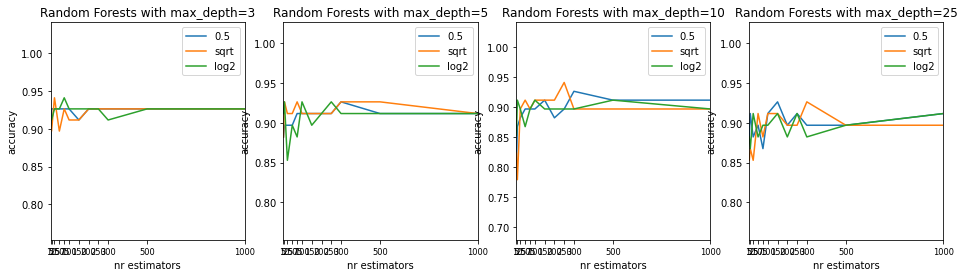

Best results with depth=3, sqrt features and 25 estimators, with accuracy=0.94


In [12]:
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300,500,1000]
max_depths = [3, 5, 10, 25]
max_features = [0.5, 'sqrt', 'log2']
best = ('', 0, 0)
last_best = 0
best_tree = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*HEIGHT, HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    miny=1
    maxy=0
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_tree = rf

        values[f] = yvalues
        if (np.min(yvalues))<miny:
            miny=np.min(yvalues)
        if (np.max(yvalues))>maxy:
            maxy=np.max(yvalues)
    multiple_line_chart(n_estimators, values, ax=axs[0, k], title=('Random Forests with max_depth={}'.format(d)),
                           xlabel='nr estimators', ylabel='accuracy', percentage=True, miny=miny, maxy=maxy)

plt.show()
print('Best results with depth={}, {} features and {} estimators, with accuracy={:.2f}'.format(best[0], best[1], best[2], last_best))


/home/aid/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[1. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


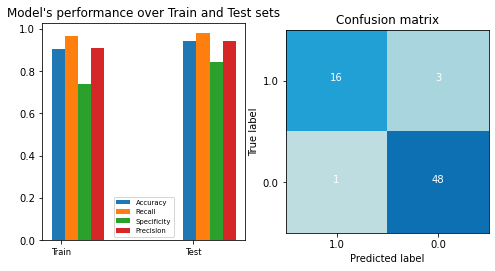

In [13]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)